## This notebook is for doing [dogs and cats challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

print(torch.__version__)
plt.ion()   # interactive mode

0.4.1


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
CHECK_POINT_PATH = 'checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 950
Validation image size: 71


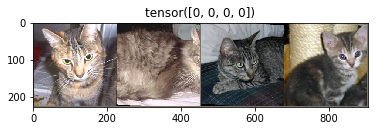

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [5]:
model_conv = torchvision.models.resnet50(pretrained=True)

In [6]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.036122415254128654, Val accuracy: 1.0
Epoch 0/2
----------
[1, 199] loss: 0.207
train Loss: 0.2218 Acc: 0.9063
val Loss: 0.0452 Acc: 0.9859

Epoch 1/2
----------
[2, 199] loss: 0.217
train Loss: 0.2185 Acc: 0.9147
val Loss: 0.0334 Acc: 1.0000
New best model found!
New record loss: 0.03336585155675109, previous record loss: 0.036122415254128654

Epoch 2/2
----------
[3, 199] loss: 0.206
train Loss: 0.1978 Acc: 0.9221
val Loss: 0.0468 Acc: 0.9859

Training complete in 9m 41s
Best val Acc: 1.0000 Best val loss: 0.0334


In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

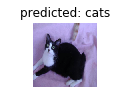

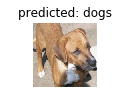

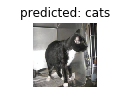

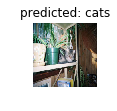

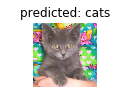

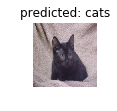

In [9]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
for param in model_conv.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [ ]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

In [ ]:
visualize_model(model_conv)

In [10]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

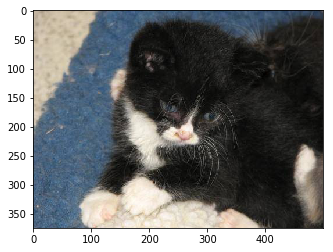

In [24]:
from PIL import Image

test_data_dir = f'{data_dir}/test'
test_data_files = os.listdir(test_data_dir)
im = Image.open(f'{test_data_dir}/{test_data_files[0]}')
plt.imshow(im)

In [25]:
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [26]:
model_conv(minibatch)

tensor([[ 2.0083, -1.8386]], grad_fn=<ThAddmmBackward>)

In [27]:
softMax = nn.Softmax(dim = 1)
preds = softMax(model_conv(minibatch))
preds

tensor([[0.9791, 0.0209]], grad_fn=<SoftmaxBackward>)

In [28]:
def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch))
    return preds[0,1].item()

In [29]:
def test_data_from_fname(fname):
    im = Image.open(f'{test_data_dir}/{fname}')
    return apply_test_transforms(im)

In [30]:
import re

def extract_file_id(fname):
    print("Extracting id from " + fname)
    return int(re.search('\d+', fname).group())

extract_file_id("cat34432.jpg")

Extracting id from cat34432.jpg


34432

In [31]:
model_conv.eval()
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv,
                                                      test_data_from_fname(fname))
                  for fname in test_data_files}

Extracting id from 9733.jpg
Extracting id from 63.jpg
Extracting id from 6400.jpg
Extracting id from 823.jpg
Extracting id from 4217.jpg
Extracting id from 3578.jpg
Extracting id from 10321.jpg
Extracting id from 2666.jpg
Extracting id from 5109.jpg
Extracting id from 11981.jpg
Extracting id from 10447.jpg
Extracting id from 2100.jpg
Extracting id from 11759.jpg
Extracting id from 4571.jpg
Extracting id from 7078.jpg
Extracting id from 12250.jpg
Extracting id from 1409.jpg
Extracting id from 9055.jpg
Extracting id from 6366.jpg
Extracting id from 12244.jpg
Extracting id from 189.jpg
Extracting id from 9041.jpg
Extracting id from 6372.jpg
Extracting id from 11995.jpg
Extracting id from 10453.jpg
Extracting id from 2114.jpg
Extracting id from 4565.jpg
Extracting id from 4203.jpg
Extracting id from 10335.jpg
Extracting id from 2672.jpg
Extracting id from 9727.jpg
Extracting id from 6414.jpg
Extracting id from 77.jpg
Extracting id from 8439.jpg
Extracting id from 837.jpg
Extracting id from

Extracting id from 566.jpg
Extracting id from 8968.jpg
Extracting id from 5294.jpg
Extracting id from 3183.jpg
Extracting id from 10902.jpg
Extracting id from 4834.jpg
Extracting id from 1794.jpg
Extracting id from 200.jpg
Extracting id from 8559.jpg
Extracting id from 957.jpg
Extracting id from 12442.jpg
Extracting id from 9647.jpg
Extracting id from 6574.jpg
Extracting id from 10255.jpg
Extracting id from 2712.jpg
Extracting id from 4363.jpg
Extracting id from 4405.jpg
Extracting id from 10533.jpg
Extracting id from 2074.jpg
Extracting id from 9121.jpg
Extracting id from 6212.jpg
Extracting id from 12324.jpg
Extracting id from 9135.jpg
Extracting id from 6206.jpg
Extracting id from 1569.jpg
Extracting id from 12330.jpg
Extracting id from 7118.jpg
Extracting id from 4411.jpg
Extracting id from 11639.jpg
Extracting id from 10527.jpg
Extracting id from 2060.jpg
Extracting id from 5069.jpg
Extracting id from 10241.jpg
Extracting id from 2706.jpg
Extracting id from 3418.jpg
Extracting id 

Extracting id from 7469.jpg
Extracting id from 1018.jpg
Extracting id from 8982.jpg
Extracting id from 9444.jpg
Extracting id from 6777.jpg
Extracting id from 10056.jpg
Extracting id from 2511.jpg
Extracting id from 11348.jpg
Extracting id from 4160.jpg
Extracting id from 3948.jpg
Extracting id from 3790.jpg
Extracting id from 6830.jpg
Extracting id from 413.jpg
Extracting id from 1187.jpg
Extracting id from 375.jpg
Extracting id from 7290.jpg
Extracting id from 1839.jpg
Extracting id from 4799.jpg
Extracting id from 10877.jpg
Extracting id from 5487.jpg
Extracting id from 4941.jpg
Extracting id from 10863.jpg
Extracting id from 5493.jpg
Extracting id from 4955.jpg
Extracting id from 361.jpg
Extracting id from 7284.jpg
Extracting id from 6824.jpg
Extracting id from 1193.jpg
Extracting id from 407.jpg
Extracting id from 8809.jpg
Extracting id from 3784.jpg
Extracting id from 8821.jpg
Extracting id from 3974.jpg
Extracting id from 10693.jpg
Extracting id from 349.jpg
Extracting id from 9

Extracting id from 2856.jpg
Extracting id from 3590.jpg
Extracting id from 9903.jpg
Extracting id from 613.jpg
Extracting id from 1387.jpg
Extracting id from 175.jpg
Extracting id from 7090.jpg
Extracting id from 4599.jpg
Extracting id from 11969.jpg
Extracting id from 5687.jpg
Extracting id from 5693.jpg
Extracting id from 161.jpg
Extracting id from 7084.jpg
Extracting id from 9917.jpg
Extracting id from 1393.jpg
Extracting id from 607.jpg
Extracting id from 2842.jpg
Extracting id from 3584.jpg
Extracting id from 4764.jpg
Extracting id from 10652.jpg
Extracting id from 2315.jpg
Extracting id from 9240.jpg
Extracting id from 6173.jpg
Extracting id from 388.jpg
Extracting id from 12045.jpg
Extracting id from 8638.jpg
Extracting id from 9526.jpg
Extracting id from 6615.jpg
Extracting id from 10134.jpg
Extracting id from 2473.jpg
Extracting id from 4002.jpg
Extracting id from 5308.jpg
Extracting id from 10120.jpg
Extracting id from 2467.jpg
Extracting id from 3779.jpg
Extracting id from 4

Extracting id from 767.jpg
Extracting id from 7682.jpg
Extracting id from 9877.jpg
Extracting id from 1595.jpg
Extracting id from 3382.jpg
Extracting id from 2088.jpg
Extracting id from 11809.jpg
Extracting id from 3396.jpg
Extracting id from 1581.jpg
Extracting id from 773.jpg
Extracting id from 6588.jpg
Extracting id from 7696.jpg
Extracting id from 9863.jpg
Extracting id from 2936.jpg
Extracting id from 5081.jpg
Extracting id from 1580.jpg
Extracting id from 3397.jpg
Extracting id from 11808.jpg
Extracting id from 2089.jpg
Extracting id from 5080.jpg
Extracting id from 2937.jpg
Extracting id from 9862.jpg
Extracting id from 7697.jpg
Extracting id from 6589.jpg
Extracting id from 772.jpg
Extracting id from 9876.jpg
Extracting id from 7683.jpg
Extracting id from 766.jpg
Extracting id from 5094.jpg
Extracting id from 2923.jpg
Extracting id from 3383.jpg
Extracting id from 1594.jpg
Extracting id from 5902.jpg
Extracting id from 11834.jpg
Extracting id from 12483.jpg
Extracting id from 8

Extracting id from 12044.jpg
Extracting id from 389.jpg
Extracting id from 6172.jpg
Extracting id from 9241.jpg
Extracting id from 2314.jpg
Extracting id from 10653.jpg
Extracting id from 4765.jpg
Extracting id from 4003.jpg
Extracting id from 2472.jpg
Extracting id from 10135.jpg
Extracting id from 6614.jpg
Extracting id from 9527.jpg
Extracting id from 8639.jpg
Extracting id from 7085.jpg
Extracting id from 160.jpg
Extracting id from 5692.jpg
Extracting id from 3585.jpg
Extracting id from 2843.jpg
Extracting id from 606.jpg
Extracting id from 1392.jpg
Extracting id from 9916.jpg
Extracting id from 1386.jpg
Extracting id from 612.jpg
Extracting id from 9902.jpg
Extracting id from 3591.jpg
Extracting id from 2857.jpg
Extracting id from 11968.jpg
Extracting id from 5686.jpg
Extracting id from 4598.jpg
Extracting id from 7091.jpg
Extracting id from 174.jpg
Extracting id from 10486.jpg
Extracting id from 11940.jpg
Extracting id from 5876.jpg
Extracting id from 11798.jpg
Extracting id from

Extracting id from 400.jpg
Extracting id from 1194.jpg
Extracting id from 6823.jpg
Extracting id from 3973.jpg
Extracting id from 8826.jpg
Extracting id from 428.jpg
Extracting id from 8198.jpg
Extracting id from 1802.jpg
Extracting id from 12083.jpg
Extracting id from 9286.jpg
Extracting id from 10694.jpg
Extracting id from 10680.jpg
Extracting id from 10858.jpg
Extracting id from 1816.jpg
Extracting id from 12097.jpg
Extracting id from 9292.jpg
Extracting id from 8832.jpg
Extracting id from 3967.jpg
Extracting id from 3620.jpg
Extracting id from 11367.jpg
Extracting id from 5251.jpg
Extracting id from 10079.jpg
Extracting id from 1037.jpg
Extracting id from 6758.jpg
Extracting id from 7446.jpg
Extracting id from 8775.jpg
Extracting id from 6980.jpg
Extracting id from 12108.jpg
Extracting id from 7320.jpg
Extracting id from 8013.jpg
Extracting id from 1989.jpg
Extracting id from 1751.jpg
Extracting id from 2258.jpg
Extracting id from 5537.jpg
Extracting id from 4629.jpg
Extracting id 

Extracting id from 6229.jpg
Extracting id from 1546.jpg
Extracting id from 7123.jpg
Extracting id from 8210.jpg
Extracting id from 1552.jpg
Extracting id from 5734.jpg
Extracting id from 3345.jpg
Extracting id from 11602.jpg
Extracting id from 3423.jpg
Extracting id from 11164.jpg
Extracting id from 5052.jpg
Extracting id from 1234.jpg
Extracting id from 9668.jpg
Extracting id from 7645.jpg
Extracting id from 978.jpg
Extracting id from 8576.jpg
Extracting id from 1963.jpg
Extracting id from 10093.jpg
Extracting id from 3812.jpg
Extracting id from 9481.jpg
Extracting id from 8947.jpg
Extracting id from 549.jpg
Extracting id from 9495.jpg
Extracting id from 8953.jpg
Extracting id from 11399.jpg
Extracting id from 10087.jpg
Extracting id from 3806.jpg
Extracting id from 10939.jpg
Extracting id from 1977.jpg
Extracting id from 4827.jpg
Extracting id from 3190.jpg
Extracting id from 10911.jpg
Extracting id from 1787.jpg
Extracting id from 213.jpg
Extracting id from 575.jpg
Extracting id fro

Extracting id from 7057.jpg
Extracting id from 8364.jpg
Extracting id from 3231.jpg
Extracting id from 11776.jpg
Extracting id from 5898.jpg
Extracting id from 5640.jpg
Extracting id from 10468.jpg
Extracting id from 2649.jpg
Extracting id from 5126.jpg
Extracting id from 2891.jpg
Extracting id from 4238.jpg
Extracting id from 3557.jpg
Extracting id from 11010.jpg
Extracting id from 7731.jpg
Extracting id from 8402.jpg
Extracting id from 1340.jpg
Extracting id from 12269.jpg
Extracting id from 7041.jpg
Extracting id from 8372.jpg
Extracting id from 1430.jpg
Extracting id from 2139.jpg
Extracting id from 5656.jpg
Extracting id from 4548.jpg
Extracting id from 3227.jpg
Extracting id from 11760.jpg
Extracting id from 8.jpg
Extracting id from 3541.jpg
Extracting id from 11006.jpg
Extracting id from 2887.jpg
Extracting id from 5130.jpg
Extracting id from 10318.jpg
Extracting id from 1356.jpg
Extracting id from 6439.jpg
Extracting id from 7727.jpg
Extracting id from 8414.jpg
Extracting id fr

Extracting id from 3186.jpg
Extracting id from 4831.jpg
Extracting id from 2298.jpg
Extracting id from 1791.jpg
Extracting id from 205.jpg
Extracting id from 1949.jpg
Extracting id from 7486.jpg
Extracting id from 6940.jpg
Extracting id from 563.jpg
Extracting id from 6798.jpg
Extracting id from 5291.jpg
Extracting id from 3838.jpg
Extracting id from 6968.jpg
Extracting id from 8945.jpg
Extracting id from 9483.jpg
Extracting id from 3810.jpg
Extracting id from 10091.jpg
Extracting id from 4819.jpg
Extracting id from 1961.jpg
Extracting id from 239.jpg
Extracting id from 1975.jpg
Extracting id from 3804.jpg
Extracting id from 10085.jpg
Extracting id from 8789.jpg
Extracting id from 8951.jpg
Extracting id from 9497.jpg
Extracting id from 1544.jpg
Extracting id from 9118.jpg
Extracting id from 7135.jpg
Extracting id from 8206.jpg
Extracting id from 3353.jpg
Extracting id from 11614.jpg
Extracting id from 5722.jpg
Extracting id from 5044.jpg
Extracting id from 3435.jpg
Extracting id from 1

Extracting id from 7322.jpg
Extracting id from 8011.jpg
Extracting id from 6982.jpg
Extracting id from 7444.jpg
Extracting id from 8777.jpg
Extracting id from 9469.jpg
Extracting id from 1035.jpg
Extracting id from 5253.jpg
Extracting id from 3622.jpg
Extracting id from 11365.jpg
Extracting id from 2528.jpg
Extracting id from 5247.jpg
Extracting id from 4159.jpg
Extracting id from 3636.jpg
Extracting id from 11371.jpg
Extracting id from 6996.jpg
Extracting id from 7450.jpg
Extracting id from 8763.jpg
Extracting id from 1021.jpg
Extracting id from 1747.jpg
Extracting id from 6028.jpg
Extracting id from 7336.jpg
Extracting id from 8005.jpg
Extracting id from 3150.jpg
Extracting id from 11417.jpg
Extracting id from 5521.jpg
Extracting id from 10709.jpg
Extracting id from 11588.jpg
Extracting id from 10696.jpg
Extracting id from 4978.jpg
Extracting id from 9284.jpg
Extracting id from 12081.jpg
Extracting id from 1800.jpg
Extracting id from 6809.jpg
Extracting id from 8824.jpg
Extracting id

Extracting id from 5624.jpg
Extracting id from 11712.jpg
Extracting id from 3255.jpg
Extracting id from 5817.jpg
Extracting id from 11921.jpg
Extracting id from 883.jpg
Extracting id from 9793.jpg
Extracting id from 7966.jpg
Extracting id from 10381.jpg
Extracting id from 10395.jpg
Extracting id from 8499.jpg
Extracting id from 897.jpg
Extracting id from 9787.jpg
Extracting id from 7972.jpg
Extracting id from 129.jpg
Extracting id from 5803.jpg
Extracting id from 11935.jpg
Extracting id from 1495.jpg
Extracting id from 101.jpg
Extracting id from 3282.jpg
Extracting id from 5195.jpg
Extracting id from 2822.jpg
Extracting id from 9977.jpg
Extracting id from 7782.jpg
Extracting id from 667.jpg
Extracting id from 9963.jpg
Extracting id from 7796.jpg
Extracting id from 6488.jpg
Extracting id from 673.jpg
Extracting id from 5181.jpg
Extracting id from 2836.jpg
Extracting id from 3296.jpg
Extracting id from 11909.jpg
Extracting id from 2188.jpg
Extracting id from 115.jpg
Extracting id from 14

Extracting id from 5988.jpg
Extracting id from 3321.jpg
Extracting id from 10578.jpg
Extracting id from 5750.jpg
Extracting id from 10593.jpg
Extracting id from 11855.jpg
Extracting id from 5963.jpg
Extracting id from 12384.jpg
Extracting id from 9181.jpg
Extracting id from 7812.jpg
Extracting id from 7806.jpg
Extracting id from 12390.jpg
Extracting id from 9195.jpg
Extracting id from 10587.jpg
Extracting id from 11841.jpg
Extracting id from 5977.jpg
Extracting id from 11699.jpg
Extracting id from 7190.jpg
Extracting id from 11869.jpg
Extracting id from 5787.jpg
Extracting id from 4499.jpg
Extracting id from 3490.jpg
Extracting id from 2956.jpg
Extracting id from 1287.jpg
Extracting id from 713.jpg
Extracting id from 9803.jpg
Extracting id from 707.jpg
Extracting id from 1293.jpg
Extracting id from 9817.jpg
Extracting id from 3484.jpg
Extracting id from 2942.jpg
Extracting id from 5793.jpg
Extracting id from 7184.jpg
Extracting id from 2943.jpg
Extracting id from 3485.jpg
Extracting id

Extracting id from 9209.jpg
Extracting id from 2374.jpg
Extracting id from 10633.jpg
Extracting id from 4705.jpg
Extracting id from 12024.jpg
Extracting id from 6112.jpg
Extracting id from 9221.jpg
Extracting id from 6674.jpg
Extracting id from 9547.jpg
Extracting id from 8881.jpg
Extracting id from 8659.jpg
Extracting id from 4063.jpg
Extracting id from 2412.jpg
Extracting id from 10155.jpg
Extracting id from 4077.jpg
Extracting id from 3718.jpg
Extracting id from 2406.jpg
Extracting id from 10141.jpg
Extracting id from 5369.jpg
Extracting id from 6660.jpg
Extracting id from 9553.jpg
Extracting id from 8895.jpg
Extracting id from 7218.jpg
Extracting id from 12030.jpg
Extracting id from 1669.jpg
Extracting id from 6106.jpg
Extracting id from 9235.jpg
Extracting id from 2360.jpg
Extracting id from 10627.jpg
Extracting id from 11539.jpg
Extracting id from 4711.jpg
Extracting id from 2837.jpg
Extracting id from 5180.jpg
Extracting id from 672.jpg
Extracting id from 6489.jpg
Extracting id 

Extracting id from 1864.jpg
Extracting id from 328.jpg
Extracting id from 1870.jpg
Extracting id from 4908.jpg
Extracting id from 3901.jpg
Extracting id from 10180.jpg
Extracting id from 8854.jpg
Extracting id from 9592.jpg
Extracting id from 6879.jpg
Extracting id from 5380.jpg
Extracting id from 3929.jpg
Extracting id from 472.jpg
Extracting id from 6689.jpg
Extracting id from 7597.jpg
Extracting id from 6851.jpg
Extracting id from 1858.jpg
Extracting id from 1680.jpg
Extracting id from 314.jpg
Extracting id from 4920.jpg
Extracting id from 2389.jpg
Extracting id from 10816.jpg
Extracting id from 3097.jpg
Extracting id from 4934.jpg
Extracting id from 10802.jpg
Extracting id from 3083.jpg
Extracting id from 300.jpg
Extracting id from 1694.jpg
Extracting id from 466.jpg
Extracting id from 8868.jpg
Extracting id from 7583.jpg
Extracting id from 6845.jpg
Extracting id from 5394.jpg
Extracting id from 4115.jpg
Extracting id from 2564.jpg
Extracting id from 10023.jpg
Extracting id from 67

Extracting id from 11102.jpg
Extracting id from 3445.jpg
Extracting id from 5034.jpg
Extracting id from 6515.jpg
Extracting id from 9626.jpg
Extracting id from 12423.jpg
Extracting id from 8538.jpg
Extracting id from 936.jpg
Extracting id from 4302.jpg
Extracting id from 2773.jpg
Extracting id from 10234.jpg
Extracting id from 11894.jpg
Extracting id from 2015.jpg
Extracting id from 10552.jpg
Extracting id from 4464.jpg
Extracting id from 12345.jpg
Extracting id from 6273.jpg
Extracting id from 9140.jpg
Extracting id from 7179.jpg
Extracting id from 12351.jpg
Extracting id from 1508.jpg
Extracting id from 6267.jpg
Extracting id from 9154.jpg
Extracting id from 11880.jpg
Extracting id from 2001.jpg
Extracting id from 10546.jpg
Extracting id from 11658.jpg
Extracting id from 4470.jpg
Extracting id from 4316.jpg
Extracting id from 3479.jpg
Extracting id from 2767.jpg
Extracting id from 10220.jpg
Extracting id from 5008.jpg
Extracting id from 6501.jpg
Extracting id from 9632.jpg
Extracting

Extracting id from 7757.jpg
Extracting id from 1326.jpg
Extracting id from 6449.jpg
Extracting id from 5140.jpg
Extracting id from 10368.jpg
Extracting id from 11076.jpg
Extracting id from 3531.jpg
Extracting id from 842.jpg
Extracting id from 6461.jpg
Extracting id from 9752.jpg
Extracting id from 5168.jpg
Extracting id from 2607.jpg
Extracting id from 10340.jpg
Extracting id from 3519.jpg
Extracting id from 4276.jpg
Extracting id from 4510.jpg
Extracting id from 11738.jpg
Extracting id from 2161.jpg
Extracting id from 10426.jpg
Extracting id from 6307.jpg
Extracting id from 9034.jpg
Extracting id from 1468.jpg
Extracting id from 12231.jpg
Extracting id from 7019.jpg
Extracting id from 6313.jpg
Extracting id from 9020.jpg
Extracting id from 12225.jpg
Extracting id from 4504.jpg
Extracting id from 2175.jpg
Extracting id from 10432.jpg
Extracting id from 2613.jpg
Extracting id from 10354.jpg
Extracting id from 4262.jpg
Extracting id from 8458.jpg
Extracting id from 856.jpg
Extracting id

Extracting id from 265.jpg
Extracting id from 1929.jpg
Extracting id from 7380.jpg
Extracting id from 4689.jpg
Extracting id from 10967.jpg
Extracting id from 4851.jpg
Extracting id from 5597.jpg
Extracting id from 3858.jpg
Extracting id from 3680.jpg
Extracting id from 6920.jpg
Extracting id from 1097.jpg
Extracting id from 503.jpg
Extracting id from 6934.jpg
Extracting id from 517.jpg
Extracting id from 1083.jpg
Extracting id from 8919.jpg
Extracting id from 3694.jpg
Extracting id from 10973.jpg
Extracting id from 4845.jpg
Extracting id from 5583.jpg
Extracting id from 271.jpg
Extracting id from 7394.jpg
Extracting id from 10783.jpg
Extracting id from 9391.jpg
Extracting id from 259.jpg
Extracting id from 12194.jpg
Extracting id from 1915.jpg
Extracting id from 8931.jpg
Extracting id from 3864.jpg
Extracting id from 3870.jpg
Extracting id from 6908.jpg
Extracting id from 8925.jpg
Extracting id from 9385.jpg
Extracting id from 12180.jpg
Extracting id from 1901.jpg
Extracting id from 1

Extracting id from 10741.jpg
Extracting id from 2206.jpg
Extracting id from 9353.jpg
Extracting id from 6060.jpg
Extracting id from 12156.jpg
Extracting id from 7418.jpg
Extracting id from 9435.jpg
Extracting id from 6706.jpg
Extracting id from 1069.jpg
Extracting id from 10027.jpg
Extracting id from 2560.jpg
Extracting id from 4111.jpg
Extracting id from 11339.jpg
Extracting id from 7430.jpg
Extracting id from 8703.jpg
Extracting id from 1041.jpg
Extracting id from 2548.jpg
Extracting id from 5227.jpg
Extracting id from 4139.jpg
Extracting id from 3656.jpg
Extracting id from 11311.jpg
Extracting id from 3130.jpg
Extracting id from 11477.jpg
Extracting id from 5541.jpg
Extracting id from 4887.jpg
Extracting id from 10769.jpg
Extracting id from 1727.jpg
Extracting id from 6048.jpg
Extracting id from 7356.jpg
Extracting id from 8065.jpg
Extracting id from 1733.jpg
Extracting id from 7342.jpg
Extracting id from 8071.jpg
Extracting id from 3124.jpg
Extracting id from 11463.jpg
Extracting i

Extracting id from 8339.jpg
Extracting id from 6314.jpg
Extracting id from 9027.jpg
Extracting id from 689.jpg
Extracting id from 6472.jpg
Extracting id from 11.jpg
Extracting id from 9741.jpg
Extracting id from 851.jpg
Extracting id from 9999.jpg
Extracting id from 4265.jpg
Extracting id from 2614.jpg
Extracting id from 10353.jpg
Extracting id from 5190.jpg
Extracting id from 2827.jpg
Extracting id from 7787.jpg
Extracting id from 9972.jpg
Extracting id from 662.jpg
Extracting id from 6499.jpg
Extracting id from 1490.jpg
Extracting id from 104.jpg
Extracting id from 3287.jpg
Extracting id from 2199.jpg
Extracting id from 11918.jpg
Extracting id from 3293.jpg
Extracting id from 110.jpg
Extracting id from 1484.jpg
Extracting id from 7793.jpg
Extracting id from 9966.jpg
Extracting id from 676.jpg
Extracting id from 5184.jpg
Extracting id from 2833.jpg
Extracting id from 8488.jpg
Extracting id from 886.jpg
Extracting id from 7963.jpg
Extracting id from 9796.jpg
Extracting id from 10384.jp

Extracting id from 6260.jpg
Extracting id from 9153.jpg
Extracting id from 12356.jpg
Extracting id from 12430.jpg
Extracting id from 7618.jpg
Extracting id from 925.jpg
Extracting id from 6506.jpg
Extracting id from 9635.jpg
Extracting id from 1269.jpg
Extracting id from 2760.jpg
Extracting id from 10227.jpg
Extracting id from 4311.jpg
Extracting id from 11139.jpg
Extracting id from 2953.jpg
Extracting id from 3495.jpg
Extracting id from 1282.jpg
Extracting id from 716.jpg
Extracting id from 9806.jpg
Extracting id from 7195.jpg
Extracting id from 5782.jpg
Extracting id from 11878.jpg
Extracting id from 5796.jpg
Extracting id from 4488.jpg
Extracting id from 7181.jpg
Extracting id from 702.jpg
Extracting id from 1296.jpg
Extracting id from 9812.jpg
Extracting id from 2947.jpg
Extracting id from 3481.jpg
Extracting id from 7817.jpg
Extracting id from 11850.jpg
Extracting id from 10596.jpg
Extracting id from 5966.jpg
Extracting id from 11688.jpg
Extracting id from 12381.jpg
Extracting id 

Extracting id from 4072.jpg
Extracting id from 2403.jpg
Extracting id from 10144.jpg
Extracting id from 8890.jpg
Extracting id from 6665.jpg
Extracting id from 9556.jpg
Extracting id from 8648.jpg
Extracting id from 11272.jpg
Extracting id from 3735.jpg
Extracting id from 5344.jpg
Extracting id from 1122.jpg
Extracting id from 8660.jpg
Extracting id from 7553.jpg
Extracting id from 6895.jpg
Extracting id from 8106.jpg
Extracting id from 7235.jpg
Extracting id from 9218.jpg
Extracting id from 1644.jpg
Extracting id from 5422.jpg
Extracting id from 11514.jpg
Extracting id from 3053.jpg
Extracting id from 2359.jpg
Extracting id from 5436.jpg
Extracting id from 4728.jpg
Extracting id from 11500.jpg
Extracting id from 3047.jpg
Extracting id from 12009.jpg
Extracting id from 8112.jpg
Extracting id from 1888.jpg
Extracting id from 7221.jpg
Extracting id from 1650.jpg
Extracting id from 1136.jpg
Extracting id from 6659.jpg
Extracting id from 8674.jpg
Extracting id from 7547.jpg
Extracting id f

Extracting id from 3710.jpg
Extracting id from 11257.jpg
Extracting id from 7576.jpg
Extracting id from 8645.jpg
Extracting id from 493.jpg
Extracting id from 1107.jpg
Extracting id from 6668.jpg
Extracting id from 478.jpg
Extracting id from 8876.jpg
Extracting id from 6683.jpg
Extracting id from 4094.jpg
Extracting id from 3923.jpg
Extracting id from 2383.jpg
Extracting id from 1852.jpg
Extracting id from 1846.jpg
Extracting id from 2397.jpg
Extracting id from 10808.jpg
Extracting id from 3089.jpg
Extracting id from 4080.jpg
Extracting id from 3937.jpg
Extracting id from 8862.jpg
Extracting id from 6697.jpg
Extracting id from 7589.jpg
Extracting id from 11280.jpg
Extracting id from 444.jpg
Extracting id from 8692.jpg
Extracting id from 6867.jpg
Extracting id from 322.jpg
Extracting id from 4916.jpg
Extracting id from 10820.jpg
Extracting id from 4902.jpg
Extracting id from 10834.jpg
Extracting id from 336.jpg
Extracting id from 450.jpg
Extracting id from 9598.jpg
Extracting id from 86

Extracting id from 2023.jpg
Extracting id from 5994.jpg
Extracting id from 4452.jpg
Extracting id from 8268.jpg
Extracting id from 12373.jpg
Extracting id from 9176.jpg
Extracting id from 6245.jpg
Extracting id from 12367.jpg
Extracting id from 9162.jpg
Extracting id from 6251.jpg
Extracting id from 5758.jpg
Extracting id from 10570.jpg
Extracting id from 2037.jpg
Extracting id from 5980.jpg
Extracting id from 3329.jpg
Extracting id from 4446.jpg
Extracting id from 4320.jpg
Extracting id from 2989.jpg
Extracting id from 11108.jpg
Extracting id from 10216.jpg
Extracting id from 2751.jpg
Extracting id from 9604.jpg
Extracting id from 6537.jpg
Extracting id from 1258.jpg
Extracting id from 12401.jpg
Extracting id from 914.jpg
Extracting id from 7629.jpg
Extracting id from 8095.jpg
Extracting id from 243.jpg
Extracting id from 10799.jpg
Extracting id from 4877.jpg
Extracting id from 10941.jpg
Extracting id from 11487.jpg
Extracting id from 525.jpg
Extracting id from 6906.jpg
Extracting id 

Extracting id from 3249.jpg
Extracting id from 10410.jpg
Extracting id from 2157.jpg
Extracting id from 5638.jpg
Extracting id from 9002.jpg
Extracting id from 6331.jpg
Extracting id from 12207.jpg
Extracting id from 9016.jpg
Extracting id from 6325.jpg
Extracting id from 12213.jpg
Extracting id from 8308.jpg
Extracting id from 4532.jpg
Extracting id from 10404.jpg
Extracting id from 2143.jpg
Extracting id from 10362.jpg
Extracting id from 2625.jpg
Extracting id from 4254.jpg
Extracting id from 860.jpg
Extracting id from 7985.jpg
Extracting id from 9770.jpg
Extracting id from 20.jpg
Extracting id from 6443.jpg
Extracting id from 12205.jpg
Extracting id from 9000.jpg
Extracting id from 6333.jpg
Extracting id from 10412.jpg
Extracting id from 2155.jpg
Extracting id from 4524.jpg
Extracting id from 4242.jpg
Extracting id from 10374.jpg
Extracting id from 2633.jpg
Extracting id from 9766.jpg
Extracting id from 36.jpg
Extracting id from 6455.jpg
Extracting id from 7993.jpg
Extracting id fro

Extracting id from 269.jpg
Extracting id from 6092.jpg
Extracting id from 1925.jpg
Extracting id from 8901.jpg
Extracting id from 2592.jpg
Extracting id from 3854.jpg
Extracting id from 6904.jpg
Extracting id from 8929.jpg
Extracting id from 527.jpg
Extracting id from 11485.jpg
Extracting id from 10943.jpg
Extracting id from 4875.jpg
Extracting id from 241.jpg
Extracting id from 9389.jpg
Extracting id from 8097.jpg
Extracting id from 255.jpg
Extracting id from 1919.jpg
Extracting id from 8083.jpg
Extracting id from 12198.jpg
Extracting id from 11491.jpg
Extracting id from 10957.jpg
Extracting id from 4861.jpg
Extracting id from 3868.jpg
Extracting id from 6910.jpg
Extracting id from 533.jpg
Extracting id from 9174.jpg
Extracting id from 6247.jpg
Extracting id from 1528.jpg
Extracting id from 12371.jpg
Extracting id from 7159.jpg
Extracting id from 4450.jpg
Extracting id from 11678.jpg
Extracting id from 5996.jpg
Extracting id from 10566.jpg
Extracting id from 2021.jpg
Extracting id fro

Extracting id from 1059.jpg
Extracting id from 9405.jpg
Extracting id from 6736.jpg
Extracting id from 3896.jpg
Extracting id from 10017.jpg
Extracting id from 2550.jpg
Extracting id from 11309.jpg
Extracting id from 4121.jpg
Extracting id from 3882.jpg
Extracting id from 10003.jpg
Extracting id from 2544.jpg
Extracting id from 4135.jpg
Extracting id from 9411.jpg
Extracting id from 6722.jpg
Extracting id from 9377.jpg
Extracting id from 6044.jpg
Extracting id from 12172.jpg
Extracting id from 8069.jpg
Extracting id from 4653.jpg
Extracting id from 10765.jpg
Extracting id from 2222.jpg
Extracting id from 10822.jpg
Extracting id from 4914.jpg
Extracting id from 320.jpg
Extracting id from 6865.jpg
Extracting id from 8690.jpg
Extracting id from 8848.jpg
Extracting id from 446.jpg
Extracting id from 11282.jpg
Extracting id from 10188.jpg
Extracting id from 3909.jpg
Extracting id from 11296.jpg
Extracting id from 6871.jpg
Extracting id from 8684.jpg
Extracting id from 452.jpg
Extracting id 

Extracting id from 5818.jpg
Extracting id from 126.jpg
Extracting id from 8496.jpg
Extracting id from 898.jpg
Extracting id from 9950.jpg
Extracting id from 640.jpg
Extracting id from 9788.jpg
Extracting id from 11084.jpg
Extracting id from 2805.jpg
Extracting id from 9978.jpg
Extracting id from 668.jpg
Extracting id from 7955.jpg
Extracting id from 6493.jpg
Extracting id from 4284.jpg
Extracting id from 5824.jpg
Extracting id from 2193.jpg
Extracting id from 11912.jpg
Extracting id from 5830.jpg
Extracting id from 3299.jpg
Extracting id from 2187.jpg
Extracting id from 11906.jpg
Extracting id from 4290.jpg
Extracting id from 2839.jpg
Extracting id from 7799.jpg
Extracting id from 7941.jpg
Extracting id from 6487.jpg
Extracting id from 1667.jpg
Extracting id from 6108.jpg
Extracting id from 8125.jpg
Extracting id from 7216.jpg
Extracting id from 11537.jpg
Extracting id from 3070.jpg
Extracting id from 5401.jpg
Extracting id from 10629.jpg
Extracting id from 2408.jpg
Extracting id from 

Extracting id from 5978.jpg
Extracting id from 11696.jpg
Extracting id from 8284.jpg
Extracting id from 7809.jpg
Extracting id from 734.jpg
Extracting id from 9824.jpg
Extracting id from 2971.jpg
Extracting id from 1288.jpg
Extracting id from 7821.jpg
Extracting id from 2959.jpg
Extracting id from 2781.jpg
Extracting id from 11866.jpg
Extracting id from 5788.jpg
Extracting id from 5950.jpg
Extracting id from 4496.jpg
Extracting id from 6281.jpg
Extracting id from 6295.jpg
Extracting id from 11872.jpg
Extracting id from 5944.jpg
Extracting id from 4482.jpg
Extracting id from 2795.jpg
Extracting id from 708.jpg
Extracting id from 7835.jpg
Extracting id from 9818.jpg
Extracting id from 4483.jpg
Extracting id from 5945.jpg
Extracting id from 11873.jpg
Extracting id from 6294.jpg
Extracting id from 9819.jpg
Extracting id from 7834.jpg
Extracting id from 709.jpg
Extracting id from 2794.jpg
Extracting id from 2780.jpg
Extracting id from 2958.jpg
Extracting id from 7820.jpg
Extracting id from 

Extracting id from 1672.jpg
Extracting id from 5414.jpg
Extracting id from 3065.jpg
Extracting id from 11522.jpg
Extracting id from 10628.jpg
Extracting id from 5400.jpg
Extracting id from 3071.jpg
Extracting id from 11536.jpg
Extracting id from 7217.jpg
Extracting id from 8124.jpg
Extracting id from 6109.jpg
Extracting id from 1666.jpg
Extracting id from 1100.jpg
Extracting id from 494.jpg
Extracting id from 7571.jpg
Extracting id from 8642.jpg
Extracting id from 3717.jpg
Extracting id from 11250.jpg
Extracting id from 4078.jpg
Extracting id from 5366.jpg
Extracting id from 2409.jpg
Extracting id from 11907.jpg
Extracting id from 2186.jpg
Extracting id from 3298.jpg
Extracting id from 5831.jpg
Extracting id from 6486.jpg
Extracting id from 7940.jpg
Extracting id from 7798.jpg
Extracting id from 2838.jpg
Extracting id from 4291.jpg
Extracting id from 4285.jpg
Extracting id from 6492.jpg
Extracting id from 7954.jpg
Extracting id from 669.jpg
Extracting id from 9979.jpg
Extracting id fro

Extracting id from 455.jpg
Extracting id from 6876.jpg
Extracting id from 8683.jpg
Extracting id from 11291.jpg
Extracting id from 4907.jpg
Extracting id from 10831.jpg
Extracting id from 333.jpg
Extracting id from 2386.jpg
Extracting id from 3098.jpg
Extracting id from 10819.jpg
Extracting id from 1857.jpg
Extracting id from 6686.jpg
Extracting id from 8873.jpg
Extracting id from 7598.jpg
Extracting id from 4091.jpg
Extracting id from 3926.jpg
Extracting id from 4085.jpg
Extracting id from 3932.jpg
Extracting id from 6692.jpg
Extracting id from 469.jpg
Extracting id from 8867.jpg
Extracting id from 1843.jpg
Extracting id from 2392.jpg
Extracting id from 5562.jpg
Extracting id from 10992.jpg
Extracting id from 3113.jpg
Extracting id from 11454.jpg
Extracting id from 7375.jpg
Extracting id from 8046.jpg
Extracting id from 9358.jpg
Extracting id from 1704.jpg
Extracting id from 290.jpg
Extracting id from 1062.jpg
Extracting id from 7413.jpg
Extracting id from 8720.jpg
Extracting id from 

Extracting id from 11131.jpg
Extracting id from 4319.jpg
Extracting id from 5007.jpg
Extracting id from 2768.jpg
Extracting id from 10549.jpg
Extracting id from 5761.jpg
Extracting id from 3310.jpg
Extracting id from 11657.jpg
Extracting id from 7176.jpg
Extracting id from 8245.jpg
Extracting id from 6268.jpg
Extracting id from 1507.jpg
Extracting id from 8912.jpg
Extracting id from 1088.jpg
Extracting id from 2581.jpg
Extracting id from 3847.jpg
Extracting id from 5588.jpg
Extracting id from 4696.jpg
Extracting id from 10978.jpg
Extracting id from 1936.jpg
Extracting id from 6081.jpg
Extracting id from 1922.jpg
Extracting id from 6095.jpg
Extracting id from 4682.jpg
Extracting id from 2595.jpg
Extracting id from 3853.jpg
Extracting id from 508.jpg
Extracting id from 8906.jpg
Extracting id from 520.jpg
Extracting id from 6903.jpg
Extracting id from 8090.jpg
Extracting id from 246.jpg
Extracting id from 4872.jpg
Extracting id from 11482.jpg
Extracting id from 10944.jpg
Extracting id fro

Extracting id from 5173.jpg
Extracting id from 3502.jpg
Extracting id from 11045.jpg
Extracting id from 3264.jpg
Extracting id from 11723.jpg
Extracting id from 5615.jpg
Extracting id from 1473.jpg
Extracting id from 7002.jpg
Extracting id from 8331.jpg
Extracting id from 4236.jpg
Extracting id from 3559.jpg
Extracting id from 10300.jpg
Extracting id from 2647.jpg
Extracting id from 5128.jpg
Extracting id from 9712.jpg
Extracting id from 6421.jpg
Extracting id from 42.jpg
Extracting id from 802.jpg
Extracting id from 7059.jpg
Extracting id from 12271.jpg
Extracting id from 1428.jpg
Extracting id from 9074.jpg
Extracting id from 6347.jpg
Extracting id from 10466.jpg
Extracting id from 2121.jpg
Extracting id from 11778.jpg
Extracting id from 5896.jpg
Extracting id from 4550.jpg
Extracting id from 10472.jpg
Extracting id from 2135.jpg
Extracting id from 4.jpg
Extracting id from 5882.jpg
Extracting id from 4544.jpg
Extracting id from 12265.jpg
Extracting id from 9060.jpg
Extracting id from

Extracting id from 6970.jpg
Extracting id from 8785.jpg
Extracting id from 553.jpg
Extracting id from 10089.jpg
Extracting id from 3808.jpg
Extracting id from 11397.jpg
Extracting id from 11383.jpg
Extracting id from 6964.jpg
Extracting id from 8791.jpg
Extracting id from 8949.jpg
Extracting id from 547.jpg
Extracting id from 221.jpg
Extracting id from 10923.jpg
Extracting id from 4815.jpg
Extracting id from 10274.jpg
Extracting id from 2733.jpg
Extracting id from 4342.jpg
Extracting id from 976.jpg
Extracting id from 8578.jpg
Extracting id from 12463.jpg
Extracting id from 7893.jpg
Extracting id from 9666.jpg
Extracting id from 6555.jpg
Extracting id from 9100.jpg
Extracting id from 6233.jpg
Extracting id from 12305.jpg
Extracting id from 4424.jpg
Extracting id from 10512.jpg
Extracting id from 2055.jpg
Extracting id from 4430.jpg
Extracting id from 11618.jpg
Extracting id from 10506.jpg
Extracting id from 2041.jpg
Extracting id from 9114.jpg
Extracting id from 6227.jpg
Extracting id 

Extracting id from 8009.jpg
Extracting id from 9303.jpg
Extracting id from 6030.jpg
Extracting id from 12106.jpg
Extracting id from 1987.jpg
Extracting id from 4627.jpg
Extracting id from 3148.jpg
Extracting id from 10711.jpg
Extracting id from 2256.jpg
Extracting id from 5539.jpg
Extracting id from 10077.jpg
Extracting id from 2530.jpg
Extracting id from 11369.jpg
Extracting id from 4141.jpg
Extracting id from 7448.jpg
Extracting id from 1039.jpg
Extracting id from 9465.jpg
Extracting id from 6756.jpg
Extracting id from 6811.jpg
Extracting id from 432.jpg
Extracting id from 3969.jpg
Extracting id from 11590.jpg
Extracting id from 10856.jpg
Extracting id from 4960.jpg
Extracting id from 354.jpg
Extracting id from 1818.jpg
Extracting id from 8182.jpg
Extracting id from 12099.jpg
Extracting id from 340.jpg
Extracting id from 9288.jpg
Extracting id from 8196.jpg
Extracting id from 11584.jpg
Extracting id from 10842.jpg
Extracting id from 4974.jpg
Extracting id from 6805.jpg
Extracting id 

Extracting id from 6393.jpg
Extracting id from 5842.jpg
Extracting id from 4584.jpg
Extracting id from 11974.jpg
Extracting id from 5856.jpg
Extracting id from 4590.jpg
Extracting id from 11960.jpg
Extracting id from 6387.jpg
Extracting id from 7099.jpg
Extracting id from 82.jpg
Extracting id from 7927.jpg
Extracting id from 2687.jpg
Extracting id from 3599.jpg
Extracting id from 9922.jpg
Extracting id from 632.jpg
Extracting id from 2877.jpg
Extracting id from 11790.jpg
Extracting id from 11948.jpg
Extracting id from 154.jpg
Extracting id from 8382.jpg
Extracting id from 12299.jpg
Extracting id from 140.jpg
Extracting id from 9088.jpg
Extracting id from 8396.jpg
Extracting id from 11784.jpg
Extracting id from 2863.jpg
Extracting id from 9936.jpg
Extracting id from 626.jpg
Extracting id from 9261.jpg
Extracting id from 6152.jpg
Extracting id from 12064.jpg
Extracting id from 4745.jpg
Extracting id from 10673.jpg
Extracting id from 2334.jpg
Extracting id from 3994.jpg
Extracting id from

Extracting id from 1588.jpg
Extracting id from 2081.jpg
Extracting id from 11800.jpg
Extracting id from 5936.jpg
Extracting id from 2095.jpg
Extracting id from 11814.jpg
Extracting id from 5922.jpg
Extracting id from 7853.jpg
Extracting id from 6595.jpg
Extracting id from 4382.jpg
Extracting id from 746.jpg
Extracting id from 8590.jpg
Extracting id from 9856.jpg
Extracting id from 11182.jpg
Extracting id from 2903.jpg
Extracting id from 11828.jpg
Extracting id from 11196.jpg
Extracting id from 2917.jpg
Extracting id from 10288.jpg
Extracting id from 752.jpg
Extracting id from 8584.jpg
Extracting id from 9842.jpg
Extracting id from 11829.jpg
Extracting id from 9843.jpg
Extracting id from 8585.jpg
Extracting id from 753.jpg
Extracting id from 10289.jpg
Extracting id from 2916.jpg
Extracting id from 11197.jpg
Extracting id from 2902.jpg
Extracting id from 11183.jpg
Extracting id from 9857.jpg
Extracting id from 8591.jpg
Extracting id from 747.jpg
Extracting id from 5923.jpg
Extracting id 

Extracting id from 10666.jpg
Extracting id from 11578.jpg
Extracting id from 4750.jpg
Extracting id from 2335.jpg
Extracting id from 10672.jpg
Extracting id from 4744.jpg
Extracting id from 12065.jpg
Extracting id from 6153.jpg
Extracting id from 9260.jpg
Extracting id from 6635.jpg
Extracting id from 9506.jpg
Extracting id from 8618.jpg
Extracting id from 4022.jpg
Extracting id from 2453.jpg
Extracting id from 10114.jpg
Extracting id from 3995.jpg
Extracting id from 11785.jpg
Extracting id from 8397.jpg
Extracting id from 9089.jpg
Extracting id from 141.jpg
Extracting id from 627.jpg
Extracting id from 9937.jpg
Extracting id from 2862.jpg
Extracting id from 2876.jpg
Extracting id from 633.jpg
Extracting id from 9923.jpg
Extracting id from 12298.jpg
Extracting id from 8383.jpg
Extracting id from 155.jpg
Extracting id from 11949.jpg
Extracting id from 11791.jpg
Extracting id from 7098.jpg
Extracting id from 6386.jpg
Extracting id from 11961.jpg
Extracting id from 4591.jpg
Extracting id 

Extracting id from 10845.jpg
Extracting id from 8191.jpg
Extracting id from 347.jpg
Extracting id from 421.jpg
Extracting id from 6802.jpg
Extracting id from 409.jpg
Extracting id from 8807.jpg
Extracting id from 2494.jpg
Extracting id from 3952.jpg
Extracting id from 4783.jpg
Extracting id from 1823.jpg
Extracting id from 6194.jpg
Extracting id from 1837.jpg
Extracting id from 6180.jpg
Extracting id from 5489.jpg
Extracting id from 4797.jpg
Extracting id from 10879.jpg
Extracting id from 2480.jpg
Extracting id from 3946.jpg
Extracting id from 8813.jpg
Extracting id from 1189.jpg
Extracting id from 582.jpg
Extracting id from 1016.jpg
Extracting id from 6779.jpg
Extracting id from 7467.jpg
Extracting id from 8754.jpg
Extracting id from 3601.jpg
Extracting id from 11346.jpg
Extracting id from 5270.jpg
Extracting id from 10058.jpg
Extracting id from 2279.jpg
Extracting id from 5516.jpg
Extracting id from 4608.jpg
Extracting id from 3167.jpg
Extracting id from 11420.jpg
Extracting id from 

Extracting id from 11623.jpg
Extracting id from 7102.jpg
Extracting id from 8231.jpg
Extracting id from 1573.jpg
Extracting id from 781.jpg
Extracting id from 1215.jpg
Extracting id from 9649.jpg
Extracting id from 7664.jpg
Extracting id from 8557.jpg
Extracting id from 959.jpg
Extracting id from 9891.jpg
Extracting id from 3402.jpg
Extracting id from 11145.jpg
Extracting id from 5073.jpg
Extracting id from 2293.jpg
Extracting id from 1942.jpg
Extracting id from 6793.jpg
Extracting id from 568.jpg
Extracting id from 8966.jpg
Extracting id from 4184.jpg
Extracting id from 3833.jpg
Extracting id from 4190.jpg
Extracting id from 3827.jpg
Extracting id from 6787.jpg
Extracting id from 8972.jpg
Extracting id from 7499.jpg
Extracting id from 1956.jpg
Extracting id from 2287.jpg
Extracting id from 3199.jpg
Extracting id from 10918.jpg
Extracting id from 232.jpg
Extracting id from 4806.jpg
Extracting id from 10930.jpg
Extracting id from 11390.jpg
Extracting id from 554.jpg
Extracting id from 6

Extracting id from 10449.jpg
Extracting id from 193.jpg
Extracting id from 1407.jpg
Extracting id from 6368.jpg
Extracting id from 7076.jpg
Extracting id from 8345.jpg
Extracting id from 7710.jpg
Extracting id from 8423.jpg
Extracting id from 1361.jpg
Extracting id from 2668.jpg
Extracting id from 5107.jpg
Extracting id from 4219.jpg
Extracting id from 3576.jpg
Extracting id from 11031.jpg
Extracting id from 2118.jpg
Extracting id from 5677.jpg
Extracting id from 11999.jpg
Extracting id from 4569.jpg
Extracting id from 3206.jpg
Extracting id from 11741.jpg
Extracting id from 12248.jpg
Extracting id from 7060.jpg
Extracting id from 8353.jpg
Extracting id from 185.jpg
Extracting id from 1411.jpg
Extracting id from 1377.jpg
Extracting id from 6418.jpg
Extracting id from 7706.jpg
Extracting id from 8435.jpg
Extracting id from 3560.jpg
Extracting id from 11027.jpg
Extracting id from 5111.jpg
Extracting id from 10339.jpg
Extracting id from 3574.jpg
Extracting id from 11033.jpg
Extracting id 

Extracting id from 6961.jpg
Extracting id from 542.jpg
Extracting id from 3831.jpg
Extracting id from 5298.jpg
Extracting id from 4186.jpg
Extracting id from 6949.jpg
Extracting id from 8964.jpg
Extracting id from 6791.jpg
Extracting id from 1798.jpg
Extracting id from 1940.jpg
Extracting id from 2291.jpg
Extracting id from 4838.jpg
Extracting id from 2285.jpg
Extracting id from 218.jpg
Extracting id from 1954.jpg
Extracting id from 8970.jpg
Extracting id from 6785.jpg
Extracting id from 3825.jpg
Extracting id from 4192.jpg
Extracting id from 3372.jpg
Extracting id from 11635.jpg
Extracting id from 5703.jpg
Extracting id from 1565.jpg
Extracting id from 9139.jpg
Extracting id from 7114.jpg
Extracting id from 8227.jpg
Extracting id from 9887.jpg
Extracting id from 7672.jpg
Extracting id from 8541.jpg
Extracting id from 797.jpg
Extracting id from 1203.jpg
Extracting id from 5065.jpg
Extracting id from 3414.jpg
Extracting id from 11153.jpg
Extracting id from 10259.jpg
Extracting id from 5

Extracting id from 11344.jpg
Extracting id from 7465.jpg
Extracting id from 8756.jpg
Extracting id from 9448.jpg
Extracting id from 1014.jpg
Extracting id from 580.jpg
Extracting id from 7471.jpg
Extracting id from 8742.jpg
Extracting id from 594.jpg
Extracting id from 1000.jpg
Extracting id from 2509.jpg
Extracting id from 5266.jpg
Extracting id from 4178.jpg
Extracting id from 3617.jpg
Extracting id from 11350.jpg
Extracting id from 3171.jpg
Extracting id from 11436.jpg
Extracting id from 5500.jpg
Extracting id from 10728.jpg
Extracting id from 1766.jpg
Extracting id from 6009.jpg
Extracting id from 7317.jpg
Extracting id from 8024.jpg
Extracting id from 6196.jpg
Extracting id from 1821.jpg
Extracting id from 7288.jpg
Extracting id from 4781.jpg
Extracting id from 4959.jpg
Extracting id from 3950.jpg
Extracting id from 2496.jpg
Extracting id from 3788.jpg
Extracting id from 6828.jpg
Extracting id from 8805.jpg
Extracting id from 8811.jpg
Extracting id from 3944.jpg
Extracting id from

In [32]:
import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(id_to_dog_prob.keys(), id_to_dog_prob.values())})
ds.head()

9733    0.020900
63      0.000267
6400    0.996489
823     0.999567
4217    0.030918
dtype: float64

In [33]:
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()

,id,label
1,1,0.996203
2,2,0.999412
3,3,0.999129
4,4,0.999782
5,5,0.000930


In [34]:
df.to_csv(SUBMISSION_FILE, index = False)

In [35]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission.csv -m "Using PyTorch"

100%|████████████████████████████████████████| 309k/309k [00:00<00:00, 85.8kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition